## Lab Report 2A
#### LT5
Cua, Gavin<br>
Garcia, Andy<br>
Macaraeg, Pauline<br>
Zornosa, Dave

Note:<br>
PCA Code in lab2a_func.py<br>
MPT Code in mpt.py

In [2]:
import lab2a_func as l2af
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import importlib
importlib.reload(l2af)


<module 'lab2a_func' from '/home/andy/Work/AIM/Subjects/Term 2/Data Mining And Wrangling/Lab2A/lab2a_func.py'>

In [3]:
import sys
!{sys.executable} -m pip install yfinance

Defaulting to user installation because normal site-packages is not writeable


## Basic Goal

## Get the list of current S&P 500 companies

In [4]:
tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
print(tickers.head())


  Symbol     Security             GICS Sector               GICS Sub-Industry  \
0    MMM           3M             Industrials        Industrial Conglomerates   
1    AOS  A. O. Smith             Industrials               Building Products   
2    ABT       Abbott             Health Care           Health Care Equipment   
3   ABBV       AbbVie             Health Care                   Biotechnology   
4    ACN    Accenture  Information Technology  IT Consulting & Other Services   

     Headquarters Location  Date added      CIK      Founded  
0    Saint Paul, Minnesota  1957-03-04    66740         1902  
1     Milwaukee, Wisconsin  2017-07-26    91142         1916  
2  North Chicago, Illinois  1957-03-04     1800         1888  
3  North Chicago, Illinois  2012-12-31  1551152  2013 (1888)  
4          Dublin, Ireland  2011-07-06  1467373         1989  


## Download the historical price data (Adj Close) and construct the design matrix

In [5]:
year = 2000
filename = f'spx_{year}_adj_close.csv'
startdate = datetime.datetime(year,1,1)
# From 2000 to 2020
df_spx = l2af.load_data(tickers, startdate, filename, days=20*365, force=False)
print(df_spx.shape)
df_spx.head()

(5028, 503)


,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WY,WMB,WTW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
2000-01-03 00:00:00,17.436209,2.330967,8.992849,NaN,NaN,16.274672,15.500,25.357716,6.878607,43.613007,...,11.427906,9.374685,NaN,NaN,6.977995,NaN,4.657411,25.027779,NaN,NaN
2000-01-04 00:00:00,16.743370,2.297380,8.735914,NaN,NaN,14.909399,14.625,24.352148,6.696075,40.281479,...,10.998601,9.166777,NaN,NaN,7.138669,NaN,4.563794,24.666668,NaN,NaN
2000-01-05 00:00:00,17.228352,2.290663,8.719851,NaN,NaN,15.204173,15.000,24.614468,6.657651,37.782799,...,11.581244,9.733794,NaN,NaN,7.414122,NaN,4.587198,25.138889,NaN,NaN
2000-01-06 00:00:00,18.614014,2.257075,9.024966,NaN,NaN,15.328290,16.000,24.811211,6.792147,36.344166,...,12.122990,9.941695,NaN,NaN,7.345258,NaN,4.548192,23.777779,NaN,NaN
2000-01-07 00:00:00,18.983524,2.351121,9.121316,NaN,NaN,16.072985,16.250,25.292133,6.926643,39.372849,...,11.724339,10.206312,NaN,NaN,7.345258,NaN,4.446774,23.513889,NaN,NaN


In [6]:

# Clean the data
df_spx = l2af.clean_data(df_spx)
print(df_spx.shape)
# df_spx


(5028, 355)


## Calculate for the returns matrix R and standardized returns Y

In [7]:

R, Y  = l2af.calculate_returns(df_spx)
# R.head()


## Construct the correlation matrix

In [8]:
filename_corr = f'correlation_matrix_{year}.csv'
p = l2af.consrtuct_correlation_matrix(Y, filename_corr, force=True)
# p.dropna(inplace=True)
p.head()

,0,1,2,3,4,5,6,7,8,9,...,345,346,347,348,349,350,351,352,353,354
0,1.000000,0.417241,0.371036,0.367749,0.275550,0.267296,0.454979,0.389132,0.555496,0.258293,...,0.331293,0.442974,0.364688,0.341597,0.265181,0.528308,0.285211,0.255303,0.401627,0.329680
1,0.417241,1.000000,0.251483,0.308117,0.286290,0.256469,0.381390,0.342662,0.419821,0.230506,...,0.246736,0.387334,0.346095,0.357184,0.271707,0.437830,0.248027,0.193304,0.329277,0.326880
2,0.371036,0.251483,1.000000,0.229366,0.168729,0.179862,0.298817,0.198120,0.354733,0.126530,...,0.313748,0.293440,0.243430,0.278718,0.145898,0.296592,0.198916,0.261711,0.304022,0.190020
3,0.367749,0.308117,0.229366,1.000000,0.364856,0.243268,0.333216,0.417614,0.361771,0.388089,...,0.215120,0.305582,0.276538,0.291843,0.324828,0.334904,0.226093,0.200766,0.296783,0.353140
4,0.275550,0.286290,0.168729,0.364856,1.000000,0.229699,0.256077,0.396757,0.296426,0.311923,...,0.126384,0.264339,0.222484,0.258528,0.332610,0.321005,0.200142,0.141664,0.222178,0.318635


## Calculate the Principal Components of the correlation matrix

In [9]:
p = np.float64(p)
# X_rotated.head()
w_prime, variance_explained, l = l2af.calculate_pca(p)

## Plot of the eigenvalues vs explained variance

Text(0, 0.5, 'Variance Explained')

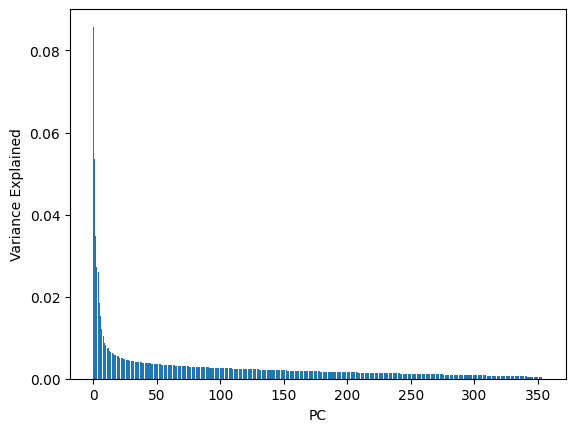

In [10]:
ev = l / np.sum(l)
plt.bar(range(len(ev)), ev)
# plt.ylim(0,1)
plt.xlabel('PC')
plt.ylabel('Variance Explained')

## Plot the Density of States

Text(0.5, 0, 'Density Of States')

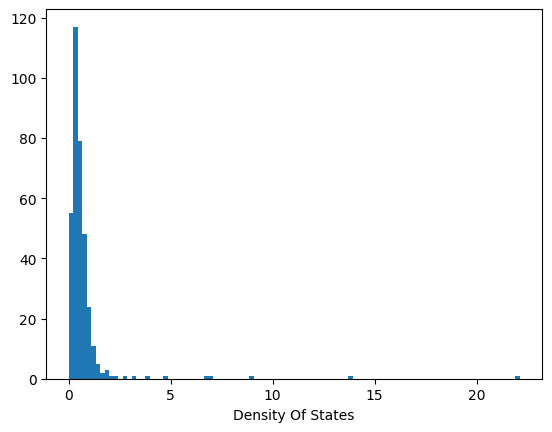

In [11]:
plt.hist(l, bins=100)
plt.xlabel('Density Of States')

## Calculate the Eigenportfolio Returns

In [12]:
# F = pd.DataFrame(w_prime)
F = l2af.calculate_eigen_returns(w_prime, R)

## Calculate SPX weighted returns

In [13]:
R_market = l2af.get_market_returns(startdate, days=20*365)
print(R_market.shape)

[*********************100%%**********************]  1 of 1 completed

(5028,)


## Plot The Actual SPX weighted returns vs. the first Eigenportfolio

5.336107849606062


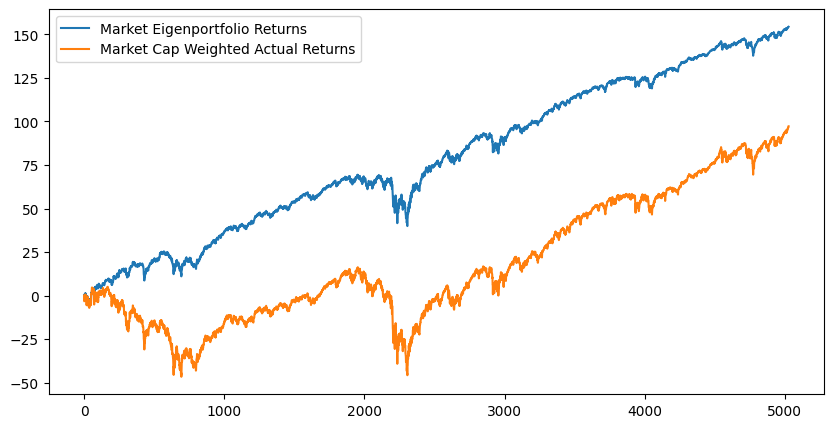

In [14]:
# RM = R.mean(axis=1)
print(max(np.abs(F[0].min()), np.abs(F[0].max())))
# data = F[0]/max(np.abs(F[0].min()), np.abs(F[0].max()))
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(F[0].cumsum(),  label="Market Eigenportfolio Returns")
ax.plot(R_market.cumsum(), label = "Market Cap Weighted Actual Returns")
plt.legend()

The difference between the returns may be attributed to changes in the index composition over time, as the Eigenportfolio returns are calculated based on current composition.

## Plot the first Eigenvector

Top 10 Stocks
    Symbol                Security  GICS Sector
57     BAC         Bank of America   Financials
121    CMA                Comerica   Financials
238    HST   Host Hotels & Resorts  Real Estate
270    JPM          JPMorgan Chase   Financials
275    KEY                 KeyCorp   Financials
298    MTB                M&T Bank   Financials
375    PNC  PNC Financial Services   Financials
453    TFC                  Truist   Financials
456    USB               U.S. Bank   Financials
488    WFC             Wells Fargo   Financials

Bottom 10 Stocks
    Symbol               Security       GICS Sector
84     CPB  Campbell Soup Company  Consumer Staples
124     ED    Consolidated Edison         Utilities
159    DUK            Duke Energy         Utilities
172    ETR                Entergy         Utilities
217    GIS          General Mills  Consumer Staples
336    NEM                Newmont         Materials
371    PCG       PG&E Corporation         Utilities
421     SO       Souther

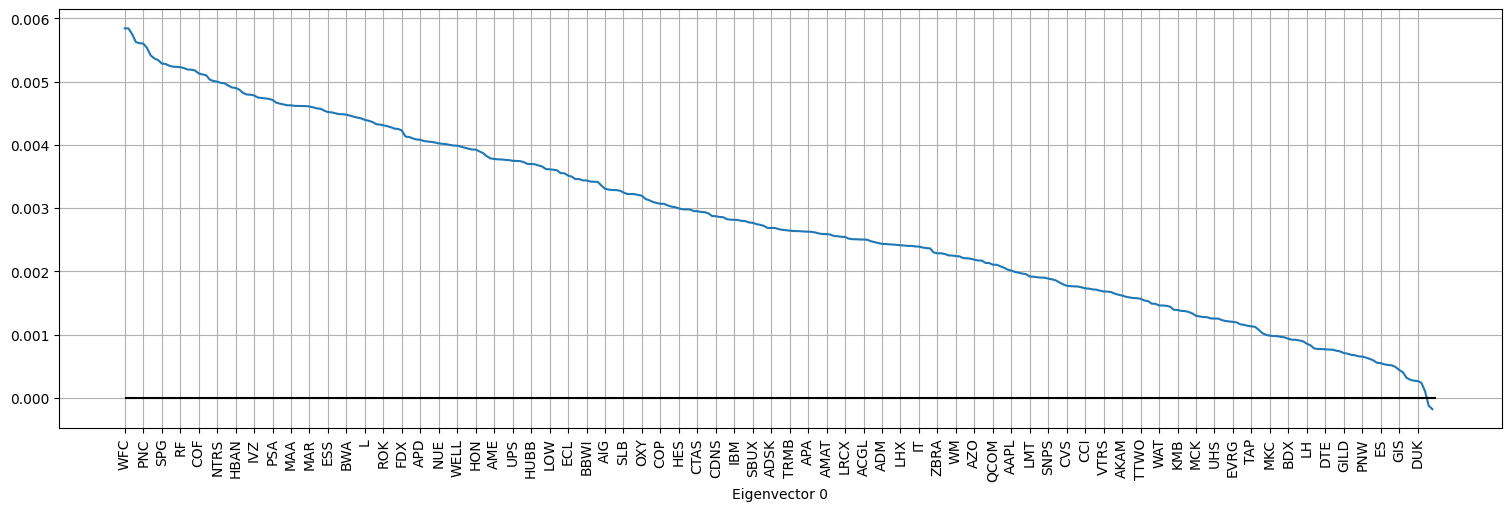

In [15]:
l2af.plot_eigenportfolio(w_prime, tickers, F, R, 0)

The first Eigenporfolio represents the Market portfolio. The composition of the top and bottom 10 stocks show the concept of coherence in the higher-order eigenvectors. The portfolio is biased more towards financial stocks and is light on utilities.

## Plot Second Eigenvector

Top 10 Stocks
    Symbol                         Security GICS Sector
24     AEE                           Ameren   Utilities
124     ED              Consolidated Edison   Utilities
153      D                  Dominion Energy   Utilities
158    DTE                       DTE Energy   Utilities
172    ETR                          Entergy   Utilities
339    NEE                   NextEra Energy   Utilities
374    PNW                    Pinnacle West   Utilities
384    PEG  Public Service Enterprise Group   Utilities
421     SO                 Southern Company   Utilities
487    WEC                 WEC Energy Group   Utilities

Bottom 10 Stocks
    Symbol              Security             GICS Sector
35     ADI        Analog Devices  Information Technology
40    AMAT     Applied Materials  Information Technology
271   JNPR      Juniper Networks  Information Technology
280   KLAC       KLA Corporation  Information Technology
285   LRCX          Lam Research  Information Technology
317   MCHP

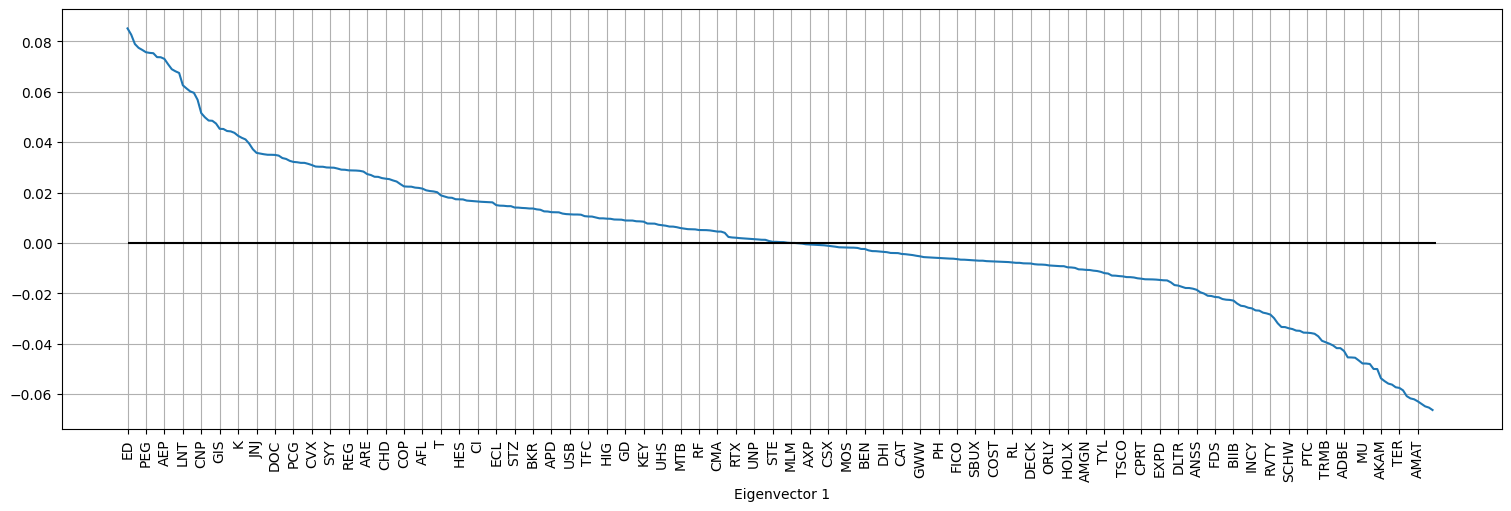

In [16]:
l2af.plot_eigenportfolio(w_prime, tickers, F, R, 1)

The second eigenvector has a high bias for utilities and a low bias for IT socks. Again, the compositions are coherent because this is a higher order eigenvector.

## Plot Third Eigenvector

Top 10 Stocks
    Symbol              Security GICS Sector
38     APA       APA Corporation      Energy
104    CVX   Chevron Corporation      Energy
123    COP        ConocoPhillips      Energy
146    DVN          Devon Energy      Energy
173    EOG         EOG Resources      Energy
189    XOM            ExxonMobil      Energy
224    HAL           Halliburton      Energy
231    HES      Hess Corporation      Energy
299    MRO          Marathon Oil      Energy
353    OXY  Occidental Petroleum      Energy

Bottom 10 Stocks
    Symbol               Security  GICS Sector
52     AVB  AvalonBay Communities  Real Estate
72     BXP      Boston Properties  Real Estate
83     CPT  Camden Property Trust  Real Estate
178    EQR     Equity Residential  Real Estate
194    FRT         Federal Realty  Real Estate
278    KIM           Kimco Realty  Real Estate
386    PSA         Public Storage  Real Estate
396    REG        Regency Centers  Real Estate
416    SPG   Simon Property Group  Real Estate
458

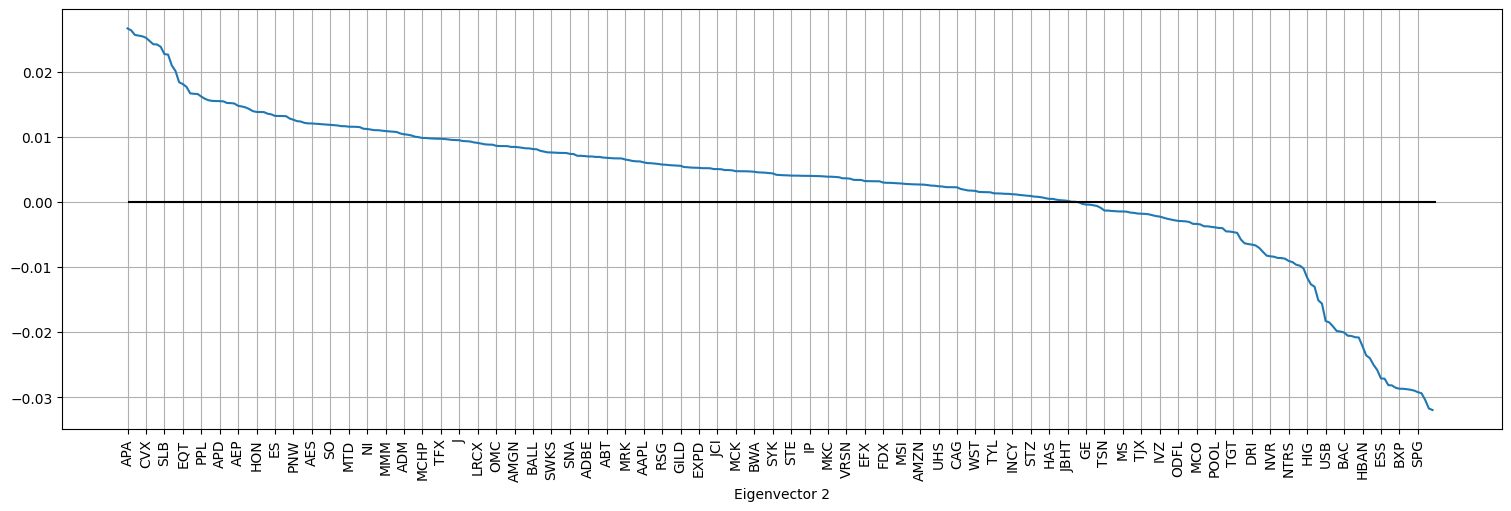

In [17]:
l2af.plot_eigenportfolio(w_prime, tickers, F, R, 2)

Again, the compositions are coherent for the third eigenvector. Notice that the dominant sectors are different for the top 3 eigenvectors, which indicate that they are indeed uncorrelated.

## Plot the lowest order Eigenvector

Top 10 Stocks
    Symbol                Security             GICS Sector
98     CNP      CenterPoint Energy               Utilities
141    DVA             DaVita Inc.             Health Care
143   DECK          Deckers Brands  Consumer Discretionary
178    EQR      Equity Residential             Real Estate
327   MNST        Monster Beverage        Consumer Staples
336    NEM                 Newmont               Materials
354   ODFL            Old Dominion             Industrials
371    PCG        PG&E Corporation               Utilities
375    PNC  PNC Financial Services              Financials
410   SBAC      SBA Communications             Real Estate

Bottom 10 Stocks
    Symbol              Security  GICS Sector
17     LNT        Alliant Energy    Utilities
24     AEE                Ameren    Utilities
109   CINF  Cincinnati Financial   Financials
207    BEN    Franklin Templeton   Financials
270    JPM        JPMorgan Chase   Financials
294      L     Loews Corporation   Financia

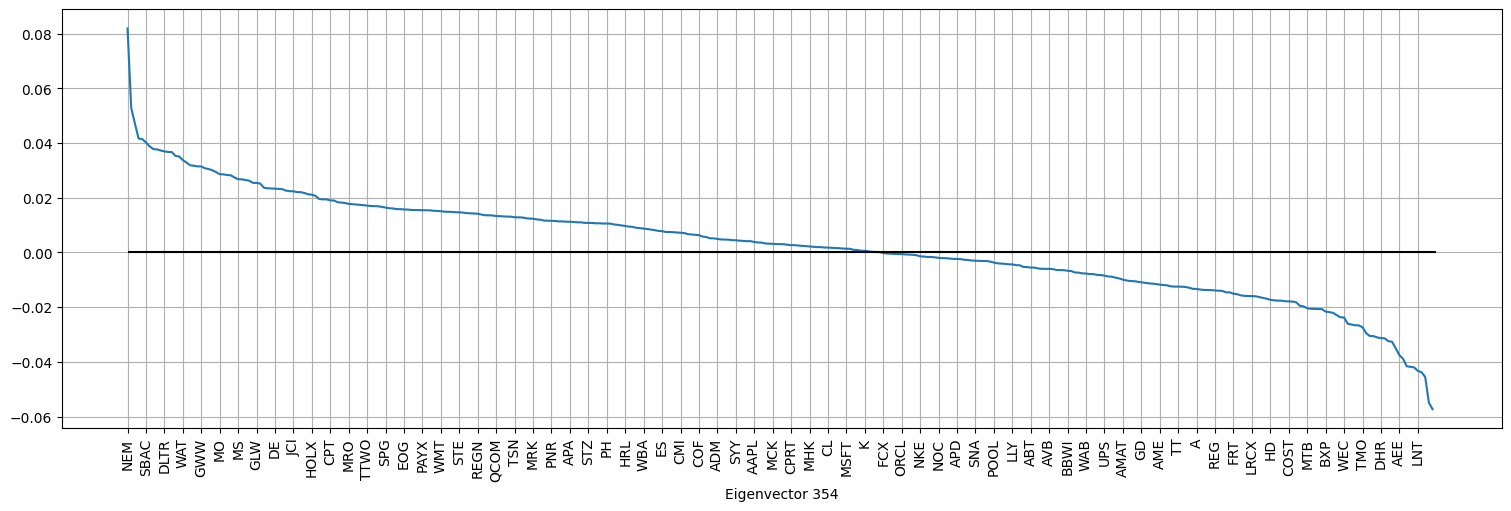

In [18]:
l2af.plot_eigenportfolio(w_prime, tickers, F, R, w_prime.shape[1] - 1)

This low-order Eigenvector represents a "noise" portfolio, where there is no coherence in industry sectors in the weighing of the stocks.

## Advanced Goal 1
#### Repeat the PCA on data right after the data we used

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


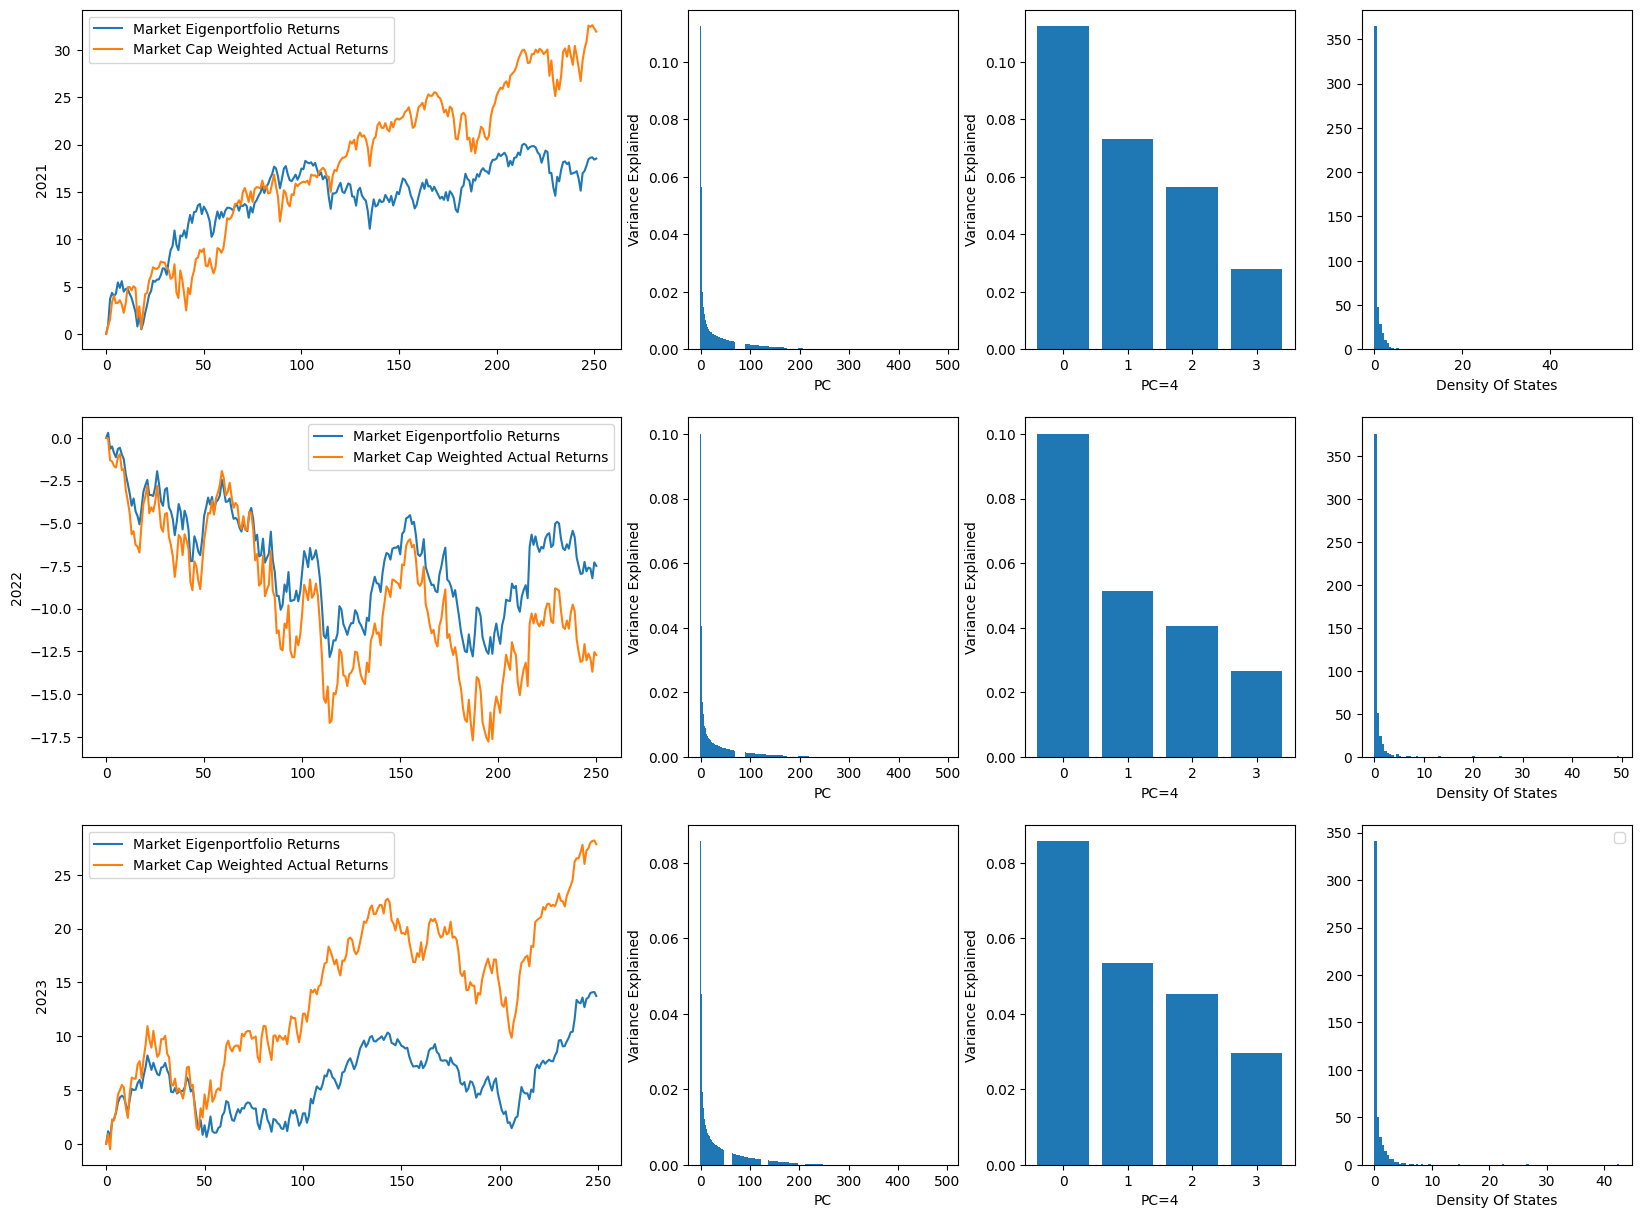

In [37]:
#Check for 2020-2024
start = 2020
fig, ax = plt.subplots(3, 4, figsize=(20,15), gridspec_kw={'width_ratios': [2, 1, 1, 1]})
for i in range(3):
    start += 1
    filename = f'spx_{start}_adj_close.csv'
    startdate = datetime.datetime(start,1,1)
    df_spx = l2af.load_data(tickers, startdate, filename, days=365, force=False)
    df_spx = l2af.clean_data(df_spx)
    R, Y = l2af.calculate_returns(df_spx)
    filename_corr = f'correlation_matrix_{start}.csv'
    p = l2af.consrtuct_correlation_matrix(Y, filename_corr, force=False)
    w_prime, variance_explained, l = l2af.calculate_pca(p)
    F = l2af.calculate_eigen_returns(w_prime, R)
    R_market = l2af.get_market_returns(startdate, days=365, )
    l2af.plot_returns(start, F, R_market, ax[i][0])
    ax[i][1].bar(range(len(l)), l/len(l))
    # plt.ylim(0,1)
    ax[i][1].set_xlabel('PC')
    ax[i][1].set_ylabel('Variance Explained')

    ax[i][2].bar(range(4), (l/len(l))[:4])
    # plt.ylim(0,1)
    ax[i][2].set_xlabel('PC=4')
    ax[i][2].set_ylabel('Variance Explained')

    ax[i][3].hist(l, bins=100)
    ax[i][3].set_xlabel('Density Of States')


    # plot_eigen_returns(F, ax[i][1])
plt.legend()



The results appear fairly consistent over different time periods.

## Advanced Goal 2
#### Check if the Eigenportfolio returns are uncorrelated:

### Visual Inspection of returns for the 1st 5 eigenportfolios

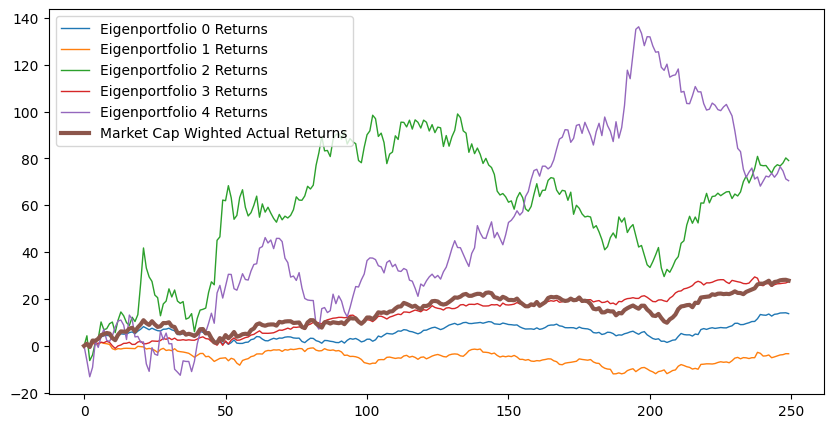

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
for i in range(5):
    ax.plot(F[i].cumsum(), linewidth=1, label=f"Eigenportfolio {i} Returns")
ax.plot(R_market.cumsum(), linewidth=3, label = "Market Cap Wighted Actual Returns")
plt.legend()

## Do Hypothesis Testing<br>
Null Hypothesis (H₀): The datasets are not correlated (correlation coefficient = 0).<br>
Alternative Hypothesis (H₁): The datasets are correlated (correlation coefficient ≠ 0).

In [21]:
from scipy.stats import pearsonr, spearmanr, kendalltau
from itertools import combinations

alpha = 0.05
p_values = {}

comb = combinations(range(len(F)), 2)
for ctr, i in enumerate(comb):
        # Pearson Correlation
        pearson_corr, pearson_p_value = pearsonr(F[i[0]].to_numpy(), F[i[1]].to_numpy())
        p_values[f'{i[0]}-{i[1]}'] = pearson_p_value 
        if ctr % 100 == 0:
            print(f'\nFor Eigenportfolio {i[0]} and {i[1]}:')
            # Interpretation
            if pearson_p_value > alpha:
                print("Pearson correlation: No significant correlation")
            else:
                print("Pearson correlation: Significant correlation")





For Eigenportfolio 0 and 1:
Pearson correlation: Significant correlation

For Eigenportfolio 0 and 101:
Pearson correlation: No significant correlation

For Eigenportfolio 0 and 201:
Pearson correlation: No significant correlation

For Eigenportfolio 1 and 53:
Pearson correlation: No significant correlation

For Eigenportfolio 1 and 153:
Pearson correlation: No significant correlation

For Eigenportfolio 2 and 6:
Pearson correlation: No significant correlation

For Eigenportfolio 2 and 106:
Pearson correlation: No significant correlation

For Eigenportfolio 2 and 206:
Pearson correlation: No significant correlation

For Eigenportfolio 3 and 60:
Pearson correlation: No significant correlation

For Eigenportfolio 3 and 160:
Pearson correlation: No significant correlation

For Eigenportfolio 4 and 15:
Pearson correlation: No significant correlation

For Eigenportfolio 4 and 115:
Pearson correlation: No significant correlation

For Eigenportfolio 4 and 215:
Pearson correlation: No signifi

## Do Holm's Step-Down Procedure

In [22]:
df_stat=pd.DataFrame()
df_stat['Eigenportfolio pair']=p_values.keys()
df_stat['p_value']=p_values.values()
alpha = 0.05
df_stat.sort_values(by='p_value', inplace=True) # Sort in place!
df_stat['L_thresholds'] = alpha/(df_stat.shape[0] + 1 - (np.arange(df_stat.shape[0]) + 1)) 
# Reject Null Hypothesis = Correlated
df_stat['correlated'] = df_stat['p_value'] < df_stat['L_thresholds']
df_stat.reset_index(drop=True, inplace=True)
print(df_stat)
correlated = max(df_stat.loc[df_stat['correlated'] == True].index +1)
not_correlated = len(df_stat.index) - correlated
print(f'\nNot Correlated: {not_correlated/(correlated+not_correlated) * 100}%')

      Eigenportfolio pair       p_value  L_thresholds  correlated
0                 248-249  4.686736e-51      0.000002        True
1                     0-1  9.522562e-20      0.000002        True
2                     0-3  1.104736e-13      0.000002        True
3                     1-3  3.385097e-11      0.000002        True
4                     0-5  2.858851e-09      0.000002        True
...                   ...           ...           ...         ...
31120              14-133  9.999966e-01      0.010000       False
31121              59-239  9.999969e-01      0.012500       False
31122             133-192  9.999971e-01      0.016667       False
31123              59-133  9.999974e-01      0.025000       False
31124             133-239  9.999991e-01      0.050000       False

[31125 rows x 4 columns]

Not Correlated: 99.97751004016064%


#### 99.97% Of Eigenportfolios show no statistically significant correlation on returns.

## Advanced Goal 3
#### Perform MPT analysis and check where the Eigenportfolios are relative to the efficient frontier

In [23]:
import mpt
importlib.reload(mpt)

<module 'mpt' from '/home/andy/Work/AIM/Subjects/Term 2/Data Mining And Wrangling/Lab2A/mpt.py'>

The efficient frontier is more apparent in plots that include a small number of stocks in a portfolio. Here we generate the MPT plot using random weights, using a random sampling of 3 stocks from the S&P 500.

In [24]:
indices = np.random.choice(range(len(R.columns)), size=3, replace=False)
R_sample=R[R.columns[indices]]
mpt_random = mpt.MPT(R_sample)
print(mpt_random.mpt_results)

(250, 3)
            0         1         2  Expected Returns  Portfolio Variance
0    0.225410  0.020368  0.754222          0.000595            0.000206
1    0.421163  0.423149  0.155688          0.000824            0.000155
2    0.290948  0.228335  0.480717          0.000686            0.000157
3    0.448798  0.022838  0.528364          0.000764            0.000203
4    0.437665  0.517747  0.044588          0.000856            0.000161
..        ...       ...       ...               ...                 ...
295  0.269983  0.147659  0.582358          0.000654            0.000172
296  0.664773  0.077567  0.257660          0.000938            0.000236
297  0.432952  0.319428  0.247620          0.000812            0.000161
298  0.334731  0.275599  0.389669          0.000729            0.000153
299  0.459812  0.051802  0.488386          0.000778            0.000199

[300 rows x 5 columns]


 Take the eigenportfolio weights of the same 3 stocks and calculate their expected returns/variance

In [25]:
mpt_eig = mpt.MPT(R_sample, weights=w_prime[:,indices])
print(mpt_eig.mpt_results)


(250, 3)
            0         1         2  Expected Returns  Portfolio Variance
0    0.348616  0.433766  0.217618          0.000772            0.000142
1    0.285205  0.366140  0.348655          0.000710            0.000140
2    0.000000  0.279324  0.720676          0.000477            0.000173
3    0.111845  0.559402  0.328753          0.000618            0.000122
4    0.794787  0.205213  0.000000          0.001062            0.000278
..        ...       ...       ...               ...                 ...
492  0.717874  0.282126  0.000000          0.001019            0.000246
493  0.657187  0.342813  0.000000          0.000986            0.000223
494  0.232270  0.000000  0.767730          0.000596            0.000211
495  0.565651  0.434349  0.000000          0.000935            0.000194
496  0.313828  0.000000  0.686172          0.000657            0.000205

[497 rows x 5 columns]


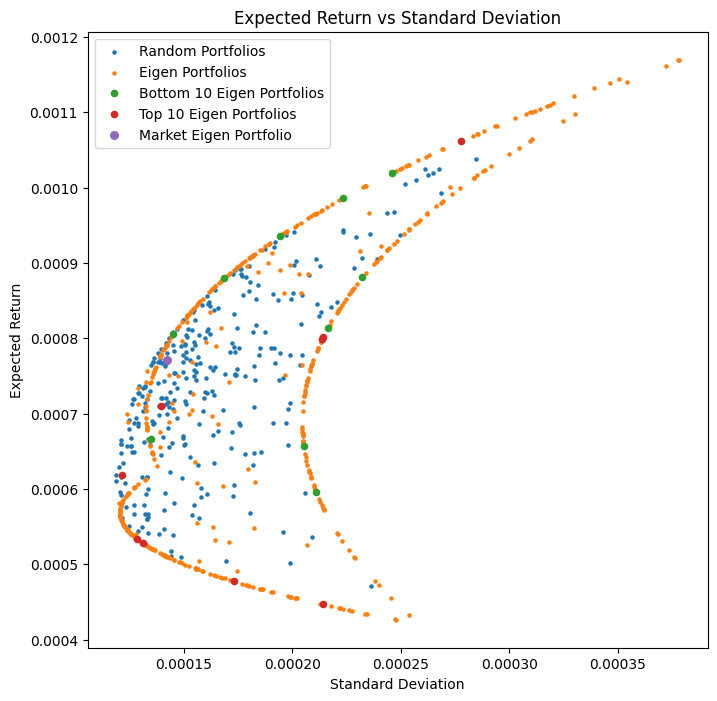

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
market_eig = mpt_eig.mpt_results.iloc[0]
top10_eig = mpt_eig.mpt_results.iloc[1:10]
mid_eig = mpt_eig.mpt_results.iloc[10:-10]
bottom_eig = mpt_eig.mpt_results.iloc[-10:]
ax.scatter(mpt_random.mpt_results['Portfolio Variance'],mpt_random.mpt_results['Expected Returns'], s=5, label="Random Portfolios")
ax.scatter( mid_eig['Portfolio Variance'],mid_eig['Expected Returns'], s=5,label="Eigen Portfolios")
ax.scatter( bottom_eig['Portfolio Variance'],bottom_eig['Expected Returns'], s=20,label="Bottom 10 Eigen Portfolios")
ax.scatter( top10_eig['Portfolio Variance'],top10_eig['Expected Returns'], s=20, label="Top 10 Eigen Portfolios")
ax.scatter( market_eig['Portfolio Variance'],market_eig['Expected Returns'], s=30, label="Market Eigen Portfolio")

ax.set_title('Expected Return vs Standard Deviation')
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Expected Return')
plt.legend()

From the plot, it appears that at least for this subset of 3 stocks of the S&P 500 the "Market" Eigenportfolio lies near the efficient frontier. This is not always the case, though. It is interesting to note that the eigenportfolios appear to line the edges of a 3-dimensional shape that is projected onto the 2-dimensional plot

In comparison if we attempt to plot the MPT results using 100 stocks:

In [27]:
indices = np.random.choice(range(len(R.columns)), size=100, replace=False)
R_sample=R[R.columns[indices]]
mpt_random = mpt.MPT(R_sample)
print(mpt_random.mpt_results)

(250, 100)
            0         1         2         3         4         5         6  \
0    0.012248  0.000213  0.001984  0.004321  0.003915  0.008069  0.010012   
1    0.001699  0.013156  0.005499  0.016706  0.008949  0.009721  0.006744   
2    0.010400  0.000358  0.005210  0.016450  0.009821  0.008374  0.005012   
3    0.000346  0.013242  0.001174  0.018865  0.018323  0.008349  0.005169   
4    0.002422  0.008769  0.013049  0.005868  0.010513  0.017658  0.007278   
..        ...       ...       ...       ...       ...       ...       ...   
295  0.014095  0.011728  0.006843  0.013071  0.009483  0.012740  0.009945   
296  0.009343  0.003870  0.005732  0.019763  0.000397  0.012942  0.014767   
297  0.012316  0.008077  0.008350  0.013009  0.018773  0.010160  0.017539   
298  0.004180  0.005349  0.017285  0.017935  0.008509  0.015673  0.009212   
299  0.003795  0.005853  0.013020  0.005830  0.020357  0.018692  0.004699   

            7         8         9  ...        92        93      

In [28]:
mpt_eig = mpt.MPT(R_sample, weights=w_prime[:,indices])
print(mpt_eig.mpt_results)


(250, 100)
            0         1         2         3         4         5         6  \
0    0.005427  0.005497  0.010178  0.012449  0.016424  0.015655  0.010465   
1    0.017955  0.010047  0.007222  0.006746  0.002911  0.005963  0.010109   
2    0.011975  0.008933  0.010496  0.013129  0.013742  0.009375  0.011833   
3    0.006301  0.010138  0.008416  0.006525  0.009624  0.008450  0.005242   
4    0.013581  0.009396  0.010372  0.003768  0.012625  0.000805  0.006339   
..        ...       ...       ...       ...       ...       ...       ...   
492  0.010645  0.007885  0.007668  0.005966  0.006895  0.008687  0.010891   
493  0.009554  0.007275  0.000227  0.011604  0.012909  0.007932  0.008643   
494  0.013766  0.001811  0.015264  0.011126  0.010169  0.006990  0.011828   
495  0.011564  0.013926  0.012951  0.013117  0.002860  0.015406  0.019734   
496  0.004958  0.012435  0.009681  0.014538  0.014248  0.003959  0.011652   

            7         8         9  ...        92        93      

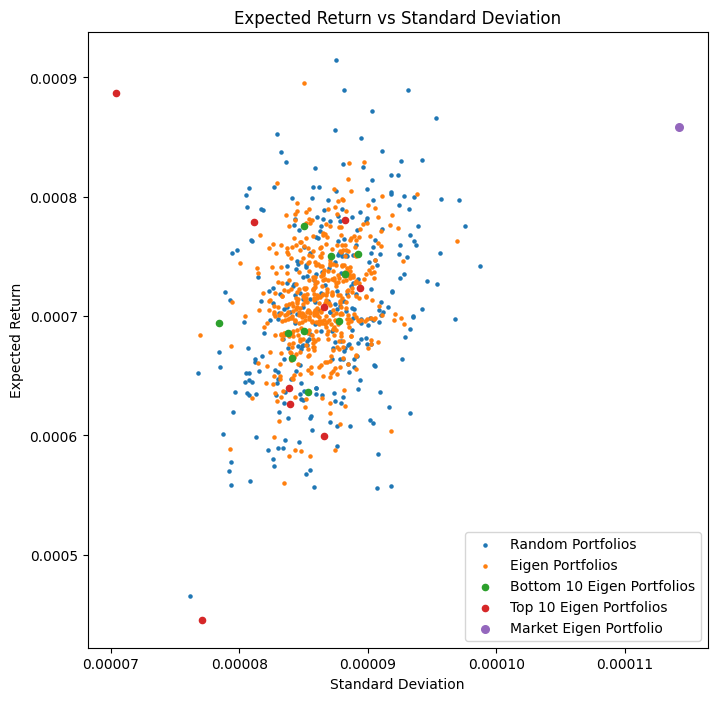

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
market_eig = mpt_eig.mpt_results.iloc[0]
top10_eig = mpt_eig.mpt_results.iloc[1:10]
mid_eig = mpt_eig.mpt_results.iloc[10:-10]
bottom_eig = mpt_eig.mpt_results.iloc[-10:]
ax.scatter(mpt_random.mpt_results['Portfolio Variance'],mpt_random.mpt_results['Expected Returns'], s=5, label="Random Portfolios")
ax.scatter( mid_eig['Portfolio Variance'],mid_eig['Expected Returns'], s=5,label="Eigen Portfolios")
ax.scatter( bottom_eig['Portfolio Variance'],bottom_eig['Expected Returns'], s=20,label="Bottom 10 Eigen Portfolios")
ax.scatter( top10_eig['Portfolio Variance'],top10_eig['Expected Returns'], s=20, label="Top 10 Eigen Portfolios")
ax.scatter( market_eig['Portfolio Variance'],market_eig['Expected Returns'], s=30, label="Market Eigen Portfolio")

ax.set_title('Expected Return vs Standard Deviation')
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Expected Return')
plt.legend()

In a larger portfolio size the plot becomes more bloblike and the efficient frontier is not so apparent.

If we plot the entire S&P 500:

In [30]:
mpt_random = mpt.MPT(R)
print(mpt_random.mpt_results)

(250, 497)
            0         1         2         3         4         5         6  \
0    0.002741  0.003523  0.002829  0.003645  0.000975  0.000958  0.003308   
1    0.001597  0.000602  0.000291  0.001394  0.003716  0.002999  0.002326   
2    0.000069  0.003528  0.000455  0.003095  0.001195  0.000886  0.001016   
3    0.002906  0.003635  0.000091  0.003261  0.002393  0.003699  0.003698   
4    0.000258  0.003568  0.001317  0.001491  0.003508  0.000916  0.000072   
..        ...       ...       ...       ...       ...       ...       ...   
295  0.001822  0.003292  0.000394  0.002908  0.001497  0.002426  0.003941   
296  0.000772  0.000386  0.003232  0.003638  0.002287  0.000308  0.000186   
297  0.000677  0.001272  0.002567  0.002260  0.000770  0.003565  0.001325   
298  0.001318  0.002368  0.000465  0.003519  0.001273  0.000447  0.003073   
299  0.002338  0.003013  0.000325  0.000383  0.003624  0.003314  0.003818   

            7         8         9  ...       489       490      

In [38]:
mpt_eig = mpt.MPT(R, weights=w_prime)
print(mpt_eig.mpt_results)

(250, 497)
            0         1         2         3         4         5         6  \
0    0.002485  0.002462  0.001303  0.000715  0.002527  0.002079  0.002395   
1    0.002255  0.001933  0.002375  0.002509  0.001231  0.000606  0.000011   
2    0.001877  0.002214  0.002426  0.001463  0.002700  0.002892  0.003203   
3    0.001298  0.002770  0.001929  0.002255  0.002434  0.003186  0.002474   
4    0.001911  0.001608  0.001087  0.001592  0.002779  0.003093  0.002824   
..        ...       ...       ...       ...       ...       ...       ...   
492  0.002012  0.002144  0.001978  0.002130  0.001500  0.002178  0.002210   
493  0.002011  0.002271  0.002096  0.001485  0.002008  0.002165  0.002213   
494  0.002008  0.001989  0.002327  0.002189  0.001582  0.002105  0.001751   
495  0.002011  0.002129  0.001245  0.002363  0.003644  0.002650  0.002051   
496  0.002010  0.002231  0.000953  0.001541  0.002893  0.002705  0.001377   

            7         8         9  ...       489       490      

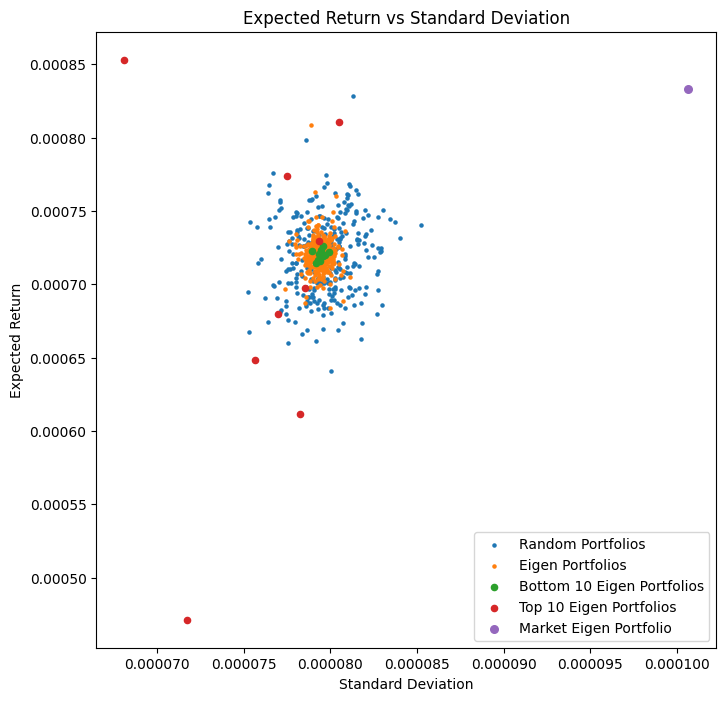

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
market_eig = mpt_eig.mpt_results.iloc[0]
top10_eig = mpt_eig.mpt_results.iloc[1:10]
mid_eig = mpt_eig.mpt_results.iloc[10:-10]
bottom_eig = mpt_eig.mpt_results.iloc[-10:]
ax.scatter(mpt_random.mpt_results['Portfolio Variance'],mpt_random.mpt_results['Expected Returns'], s=5, label="Random Portfolios")
ax.scatter( mid_eig['Portfolio Variance'],mid_eig['Expected Returns'], s=5,label="Eigen Portfolios")
ax.scatter( bottom_eig['Portfolio Variance'],bottom_eig['Expected Returns'], s=20,label="Bottom 10 Eigen Portfolios")
ax.scatter( top10_eig['Portfolio Variance'],top10_eig['Expected Returns'], s=20, label="Top 10 Eigen Portfolios")
ax.scatter( market_eig['Portfolio Variance'],market_eig['Expected Returns'], s=30, label="Market Eigen Portfolio")

ax.set_title('Expected Return vs Standard Deviation')
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Expected Return')
plt.legend()

The plot becomes that of a main central blob and several isolated higher order Eigenportfolios, which is consistent with what we saw in the Density of States plot. It is also interesting to note that the bottom 10 Eigenporfolios all lie near the center of the main blob, which is consitent with PCA analysis for less significant/noise components.